In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from matplotlib import colors
import numpy as np
import csv
import json

import sqlalchemy
from sqlalchemy import create_engine
from getpass import getpass

pd.set_option('display.max_rows', 500)

import pendulum
pendulum.week_starts_at(pendulum.SUNDAY)
pendulum.week_ends_at(pendulum.SATURDAY)
from datetime import datetime as dt

In [2]:
password = getpass()
engine = create_engine(#db info omitted for security reasons)

········


In [3]:
#this code divides the daterange into 'weeks' as defined by the company's accounting (starting on Sunday and ending on Saturday)
def dater(startdate,enddate):
    s1 = dt.strptime(startdate, "%Y-%m-%d")
    e1 = dt.strptime(enddate, "%Y-%m-%d")
    da = int((e1 - s1).days / 7)
    dr_dict = {}
    for i in range(0,da+1): 
        sd = pendulum.instance(s1).add(weeks=i).start_of('week')
        ed = sd.end_of('week')
        dr_dict[i] = sd.to_date_string(), ed.to_date_string()
    ka = pendulum.instance(s1).start_of('week').to_date_string(), pendulum.instance(e1).end_of('week').to_date_string()
    da2 = da+1
    dr_dict[da2] = ka
    return dr_dict  

In [12]:
#this code queries the database for the required data
def getrevs(startdate,enddate):
    startdate='\'' + startdate + '\''
    enddate='\'' + enddate + '\''
          
    qur = '''
    WITH quan AS (
    SELECT
        k.Id AS kitchenId,
        k.FranchiseId AS franId,
        k.Name,
        SUM(CASE
            WHEN ft.Name = 'Meal' THEN oi.Quantity
            ELSE 0
        END) AS mealcount,
        SUM(CASE
            WHEN ft.Name = 'Snack' THEN oi.Quantity
            ELSE 0
        END) AS snackcount
    FROM
        orderitems AS oi
            JOIN
        orders AS o ON o.Id = oi.OrderId
            JOIN
        menutemplates AS mt ON oi.MenuTemplateId = mt.Id
            JOIN
        programs AS pro ON mt.ProgramId = pro.Id
            JOIN
        customers AS c ON c.Id = o.CustomerId
            JOIN
        rooms r ON c.RoomId = r.Id
            JOIN
        deliverylocations dl ON r.DeliveryLocationId = dl.Id
            JOIN
        kitchens k ON dl.KitchenId = k.Id
            JOIN
        productfoodtags AS pft ON oi.ProductId = pft.ProductId
            JOIN
        foodtags AS ft ON pft.FoodTagId = ft.Id
            JOIN
        tagtypes AS tt ON ft.TagTypeId = tt.Id
    WHERE
        o.OrderDate BETWEEN {startdate} AND {enddate}
    GROUP BY k.FranchiseId),
    init AS (
    SELECT 
        ROUND(SUM(tr.Amount), 2) AS amount,
        fr.Name AS franchise,
        fr.Id AS frid, 
        CASE
            WHEN prg.Name IN ('Core' , 'Core Specials') THEN 'Program Type 1'
            WHEN prg.Name IN ('DIY ', 'Managed Platform') THEN 'Program Type 2'
            WHEN prg.Name IN ('CC/Snk Tax' , 'CC/Snk No Tax') THEN 'Program Type 3'
            WHEN prg.Name IN ('Nutrition') THEN 'Program Type 4'
            ELSE 'Program Type 5'
        END AS category,
        SUM(CASE
            WHEN tr.Amount > 0 AND ft.Name = 'Meal' THEN oi.quantity
            ELSE 0
        END) AS mealcount,
        SUM(CASE
            WHEN tr.Amount > 0 AND ft.Name = 'Snack' THEN oi.quantity
            ELSE 0
        END) AS snackcount
    FROM
        transactions AS tr
            JOIN
        franchises AS fr ON tr.FranchiseId = fr.Id
            JOIN
        orders AS ords ON tr.OrderId = ords.Id
            JOIN
        orderitems AS oi ON tr.OrderItemId = oi.Id
            JOIN
        products AS pr ON tr.ProductId = pr.Id
            JOIN
        menutemplates AS mt ON oi.MenuTemplateId = mt.Id
            JOIN
        programs AS prg ON mt.ProgramId = prg.Id
            JOIN
        productfoodtags AS pft ON tr.ProductId = pft.ProductId
            JOIN
        foodtags AS ft ON pft.FoodTagId = ft.Id
            JOIN
        tagtypes AS tt ON ft.TagTypeId = tt.Id
    WHERE
        ords.OrderDate BETWEEN {startdate} AND {enddate}
            AND ords.CancelDate IS NULL
            AND oi.Cancel != 1
            AND fr.Name != 'Demo Franchise Ontario'
            AND tt.Id = 2
    GROUP BY fr.Name, category)
    SELECT 
        i.frid AS franchisee,
        SUM(CASE
            WHEN i.category = 'Program Type 1' THEN i.amount
            ELSE 0
        END) AS ProgramType1,
        SUM(CASE
            WHEN i.category = 'Program Type 2' THEN i.amount
            ELSE 0
        END) AS ProgramType2,
        SUM(CASE
            WHEN i.category = 'Program Type 3' THEN i.amount
            ELSE 0
        END) AS ProgramType3,
        SUM(CASE
            WHEN i.category = 'Program Type 4' THEN i.amount
            ELSE 0
        END) AS ProgramType4,
        SUM(CASE
            WHEN i.category = 'Program Type 5' THEN i.amount
            ELSE 0
        END) AS ProgramType5,
        SUM(i.amount) AS total,
        q.mealcount AS mealcount2, 
        q.snackcount AS snackcount2
    FROM
        init AS i
    JOIN quan AS q ON i.frid = q.franId
    GROUP BY i.frid
    ORDER BY total DESC
    '''.format(startdate=startdate,enddate=enddate)
    tab = pd.read_sql(qur,engine)
    return tab

In [22]:
#this code charts the data brought in from the database
def charter(dictionary,report_name='Report'):
    
    django = {}
    count = len(dictionary.keys())
    
    for numer, (k,v) in zip(range(0,count),dictionary.items()):
        
        frs22 = v
        
        startdate = k[0]
        enddate = k[1]

        so_oppo_df = frs22[['ProgramType1','ProgramType2','ProgramType3','ProgramType4','ProgramType5']]
        per = so_oppo_df.sum()

        cmap3 = plt.cm.get_cmap('tab10')

        names = [i for i in range(1,len(frs22['franchisee']) + 1)]

        fig1, ax = plt.subplots(figsize=(20,13))

        x = so_oppo_df.index
        indexes = np.argsort(so_oppo_df.values).T
        heights = np.sort(so_oppo_df.values).T
        order = -1
        bottoms = heights[::order].cumsum(axis=0)
        bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

        mpp_colors = dict(zip(so_oppo_df.columns, cmap3.colors))

        for k, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):
            mps = np.take(np.array(so_oppo_df.columns), idxs)
            ax.bar(so_oppo_df.index, height=vals, bottom=bottoms[k], color=[mpp_colors[m] for m in mps],width=.95, linewidth=0,edgecolor='none')

        ld = {}
        for l,pr in zip(cmap3.colors,per.index): 
            ld[pr] = l
        ld['Meal Count'] = '#0000004D'
        ld['Snack Count'] = '#0000001A'    

        patchList = []
        for key in ld:
            data_key = mpatches.Patch(color=ld[key], label=key)
            patchList.append(data_key)    

        ax.margins(0.00)

        for location in ['left','right','top','bottom']:
            ax.spines[location].set_visible(False)
        ax.tick_params(top=False, bottom=False, left=False, right=False)

        ax2 = frs22['mealcount2'].plot.bar(color='black',ax=ax,label='Meal Count',legend=True, alpha=.3, width=.6)

        frs22['snackcount2'].plot.bar(color='black',ax=ax2, label='Snack Count',legend=True, alpha=.1, width=.6,bottom=frs22['mealcount2'])

        left, bottom, width, height = [0.73, 0.53, 0.2, 0.2]
        ax3 = fig1.add_axes([left, bottom, width, height])
        per.plot.pie(labels='$' + per.round(2).astype(str),ax=ax3,labeldistance=1.1,textprops={'fontsize': 14})
        ax3.set_ylabel('')
        ax3.set_title('Total Revenue',pad=-10,fontsize=20)

        ax.set_title('Report\n{} - {}'.format(startdate,enddate),fontsize=20,pad=-32)
        for location in ['left','right','top','bottom']:
            ax.spines[location].set_visible(False)
        ax.tick_params(top=False, bottom=False, left=False, right=False)

        ax.legend(patchList, ld.keys(), bbox_to_anchor=(.85, 1), loc='upper left', ncol=1, frameon=False, fontsize=10)
        ax.get_legend().set_title('')
        ax.set_xlabel('Franchise')
        ax.set_ylabel('Revenue')
#         ax.set_ylabel('')
        ax.set_xticklabels(names, rotation = 0)
        xx = frs22['total'].sum().round(2).copy()
        ax.text(.915, .515, '${}'.format(xx), horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=20)

        ax.bar_label(ax.containers[4],'$' + frs22['total'].round(2).astype(str))

        django[numer] = fig1

        plt.show()

    fig2,ax = plt.subplots(figsize=(15,15))
    ax.text(5, 5, 'Report', fontsize=100)
    img2 = plt.imread('Pictures/insert logo.jpg')
    ax.imshow(img2)
    ax.axis(False)

    pp11 = PdfPages("{}.pdf".format(report_name))
    pp11.savefig(fig2, bbox_inches='tight',dpi=100,edgecolor='white')
    for k,v in django.items(): 
        pp11.savefig(v, bbox_inches='tight',dpi=100,edgecolor='white')
    pp11.close()

In [23]:
#this code organizes creates a dictionary with the 'weeks' within the daterange selected as the keys, and dataframes containing data for those 'weeks' as values
def report_maker(startdate,enddate,report_name='Report'):
    hern = dater(startdate,enddate)
    hern_dict = {}
    for k,v in hern.items(): 
        hern_dict[v] = getrevs(v[0],v[1])
    charter(hern_dict,report_name='Report')

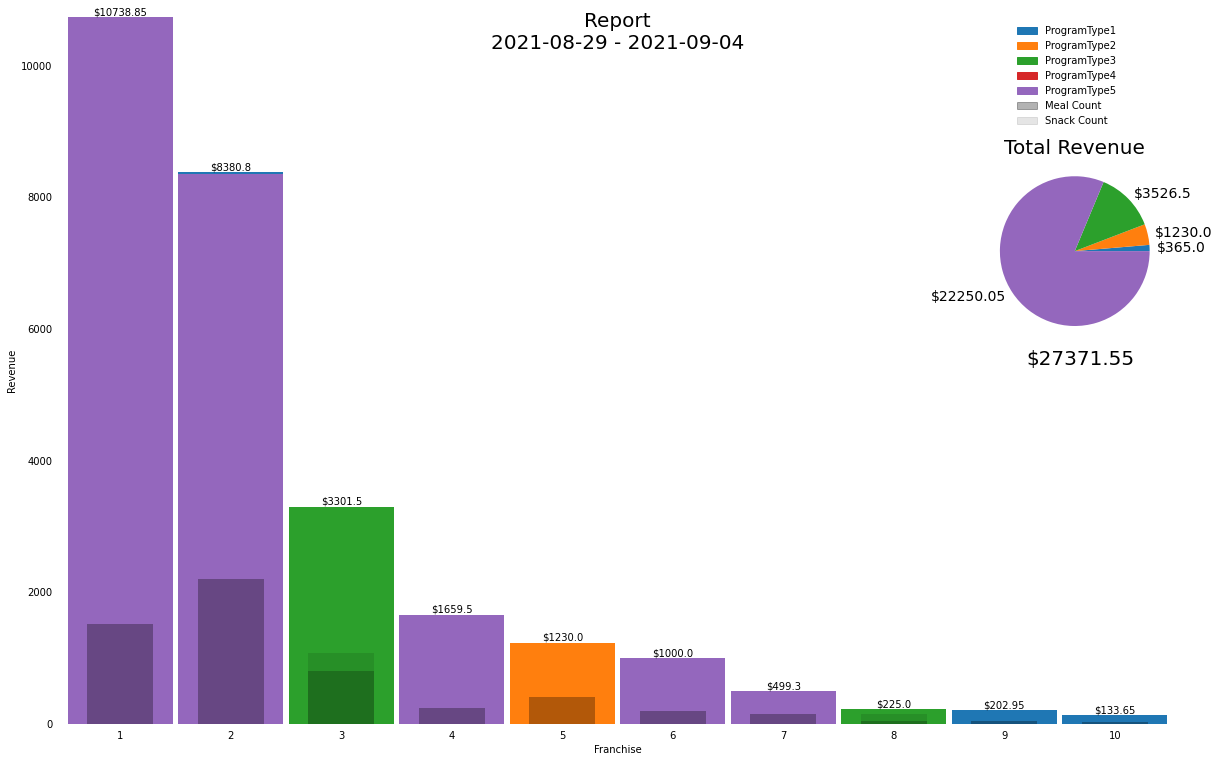

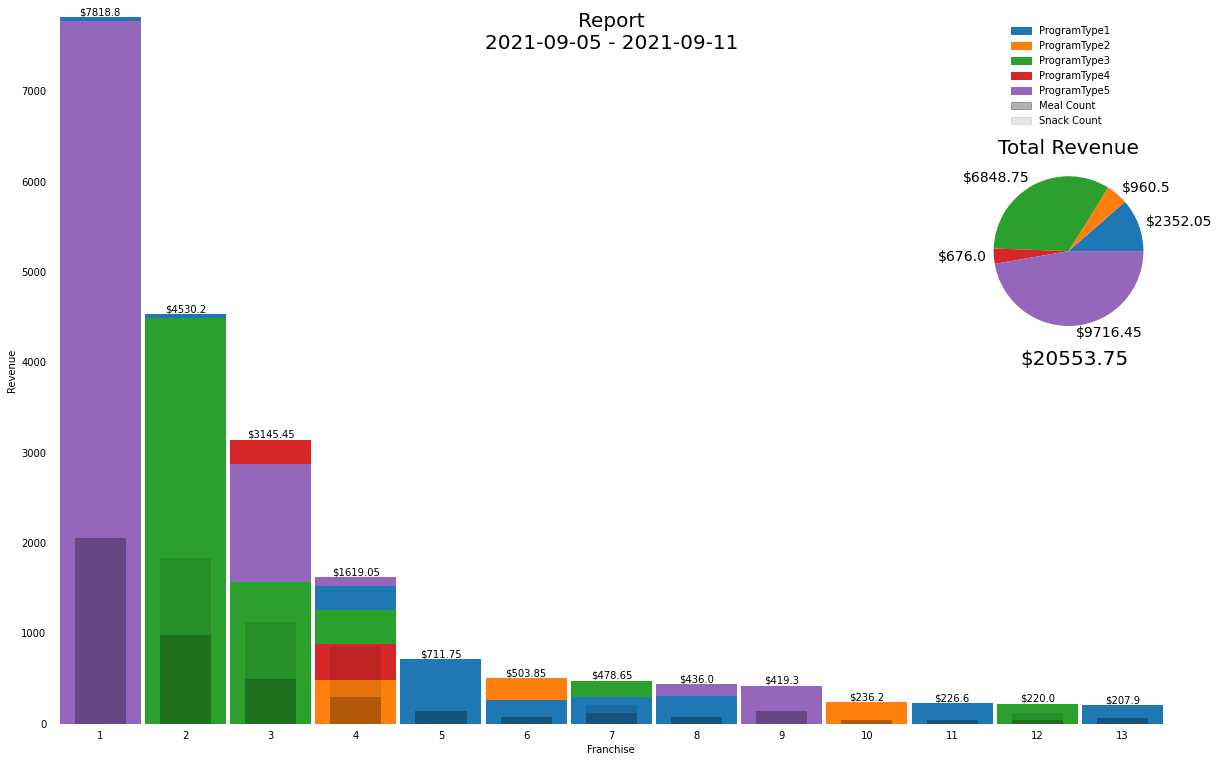

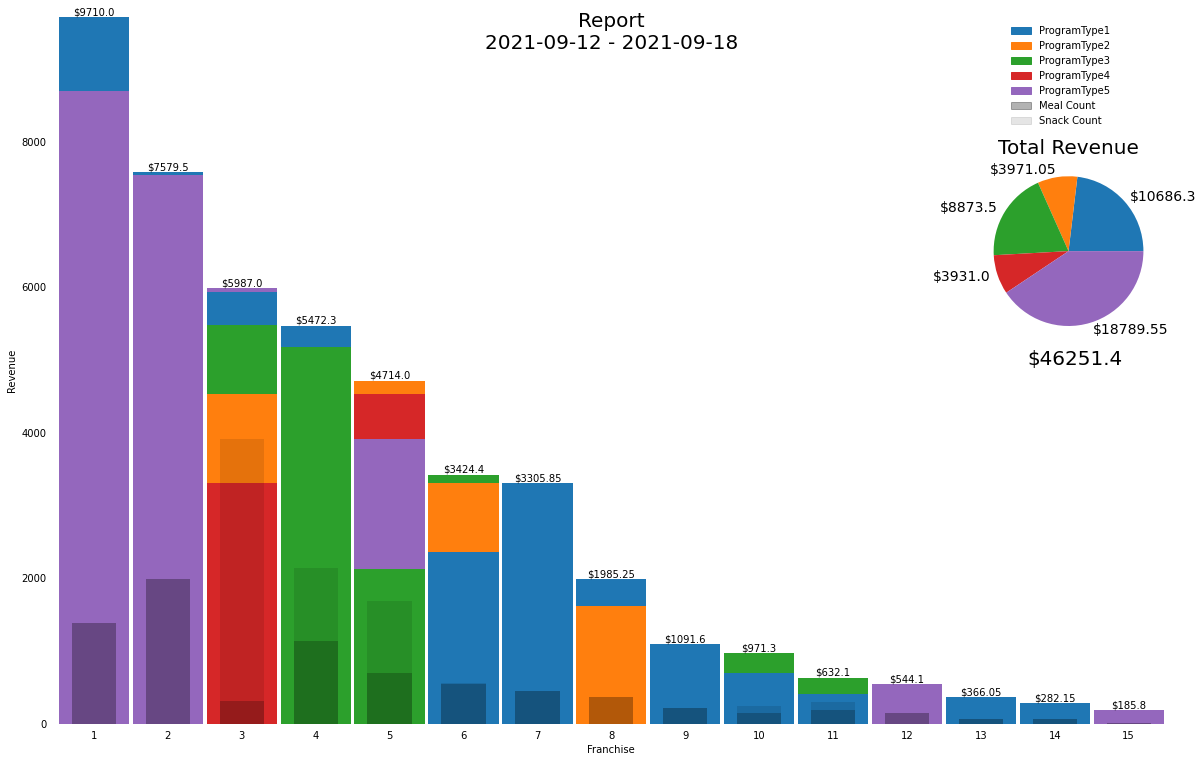

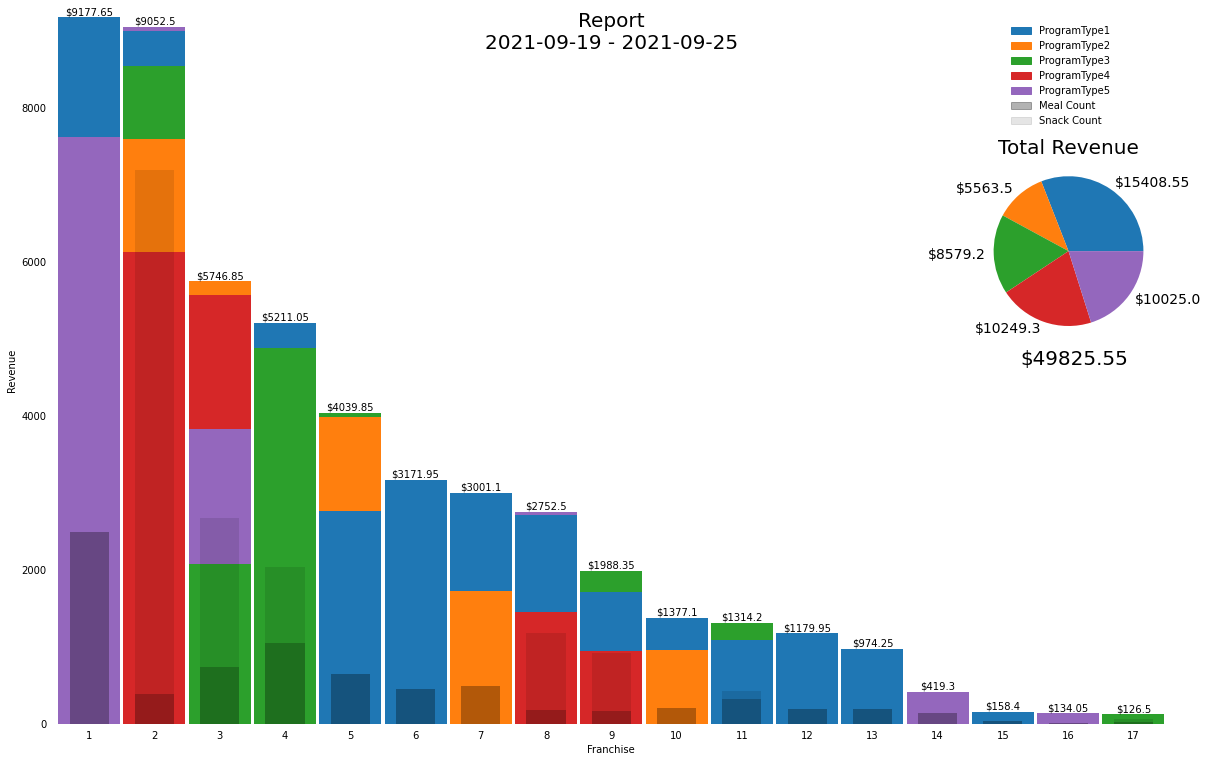

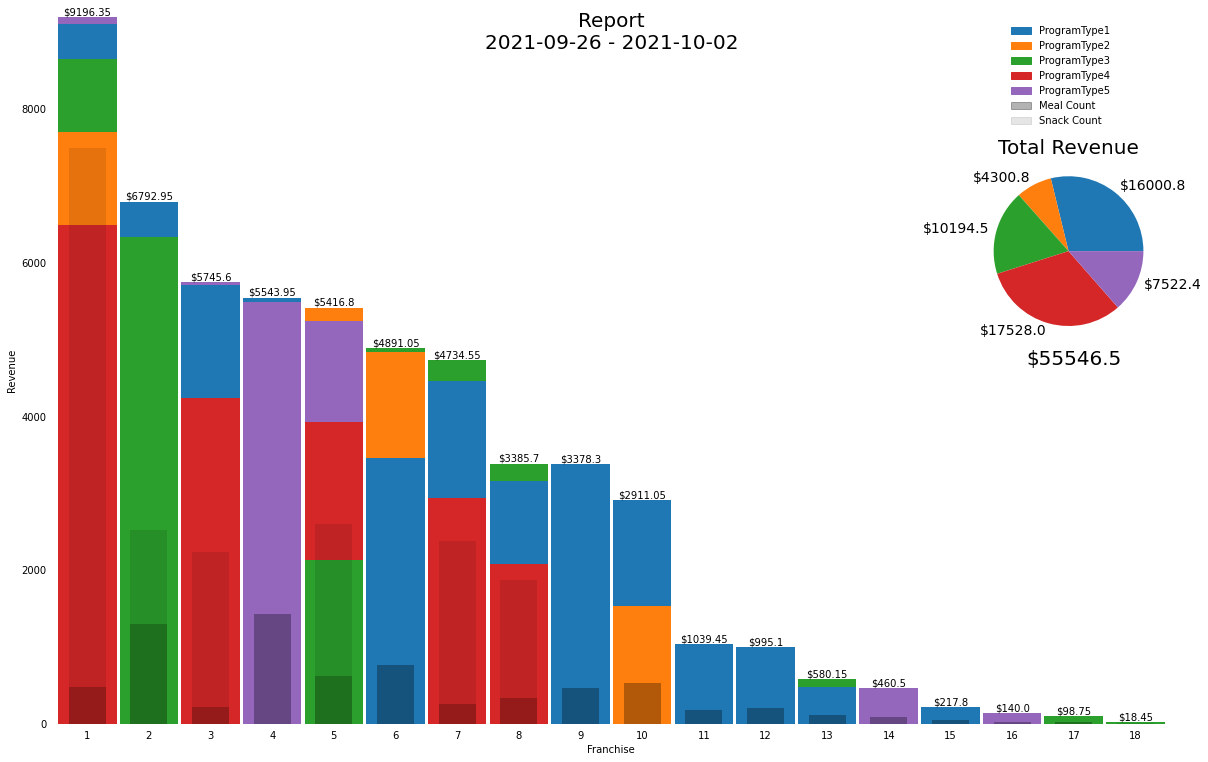

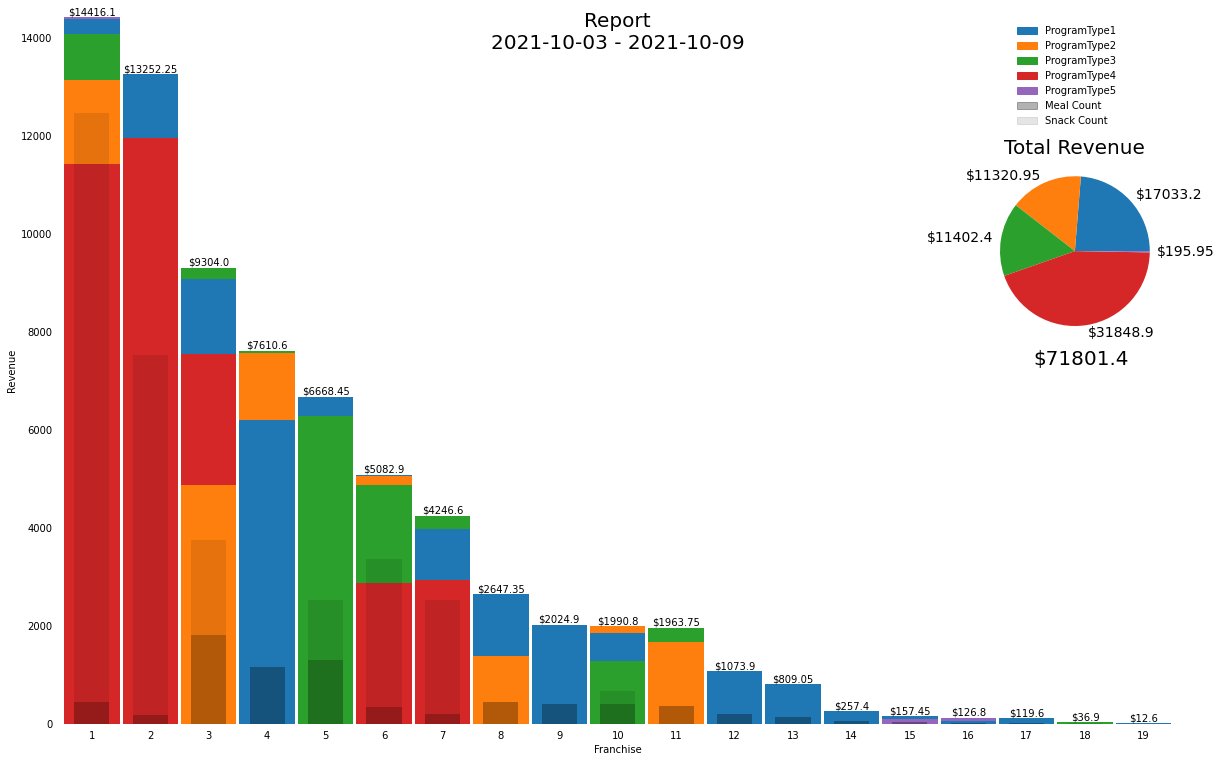

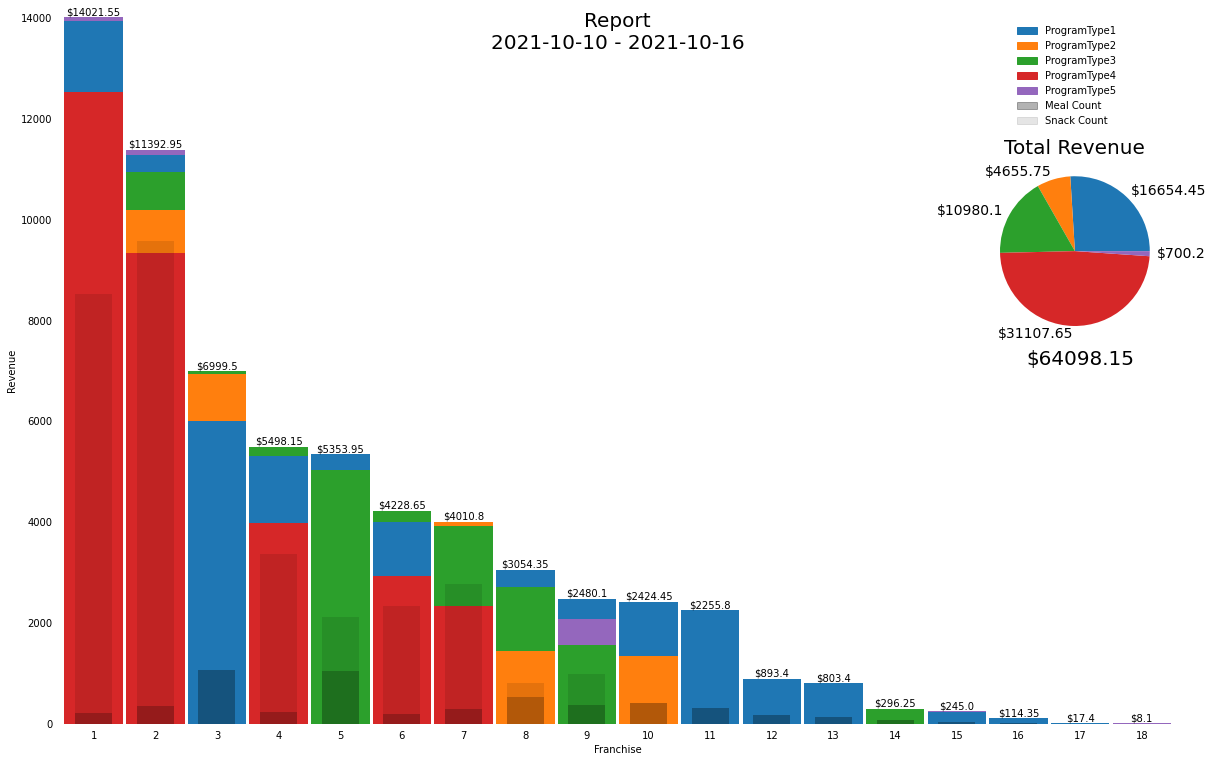

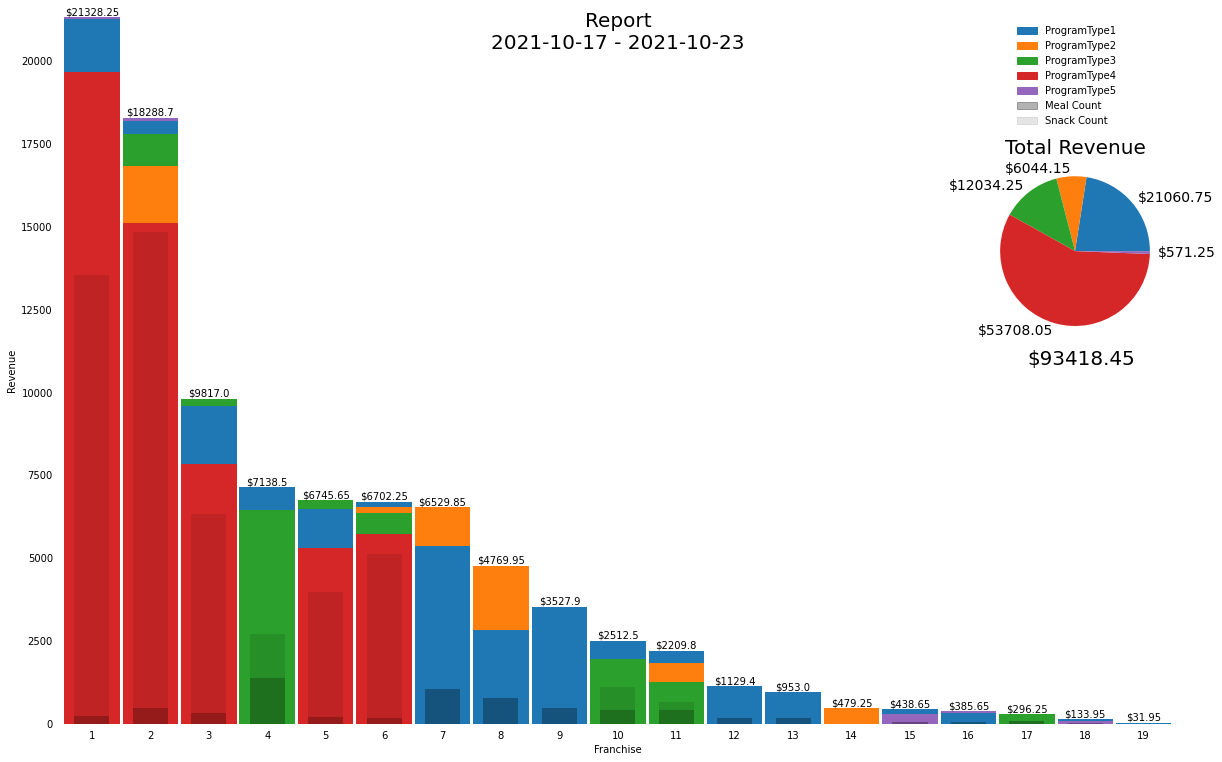

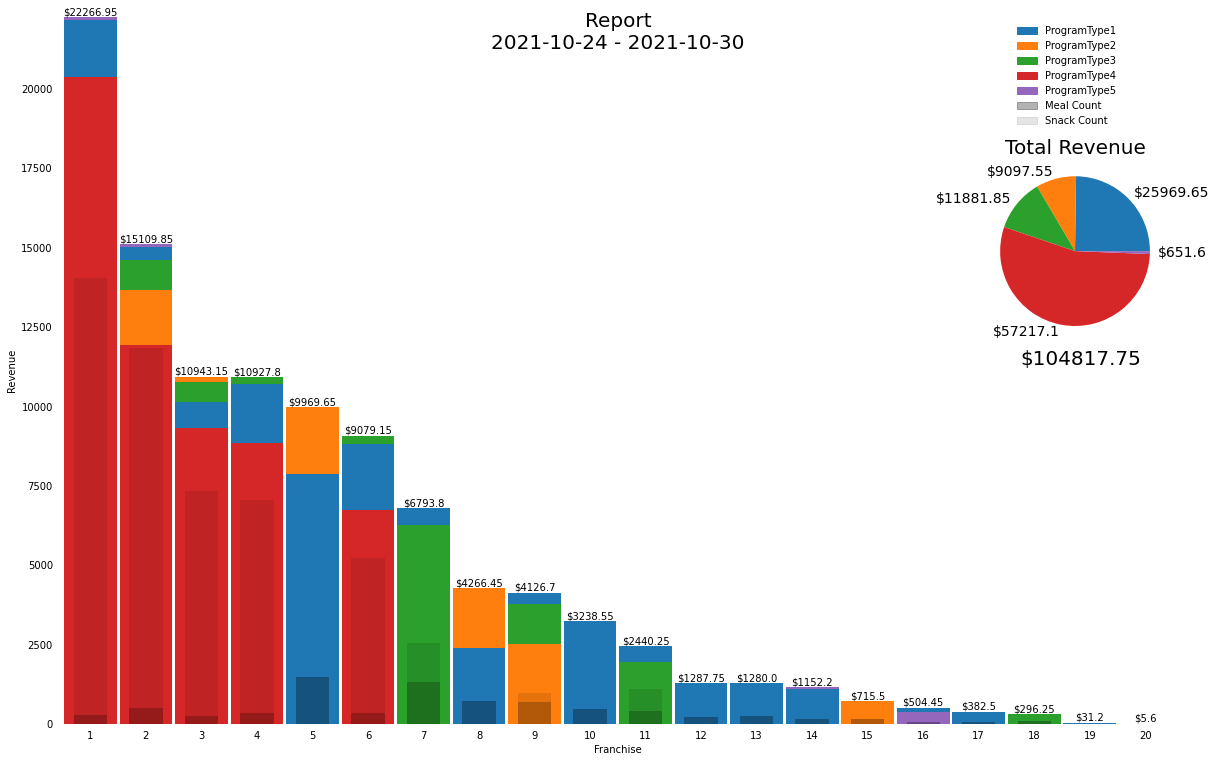

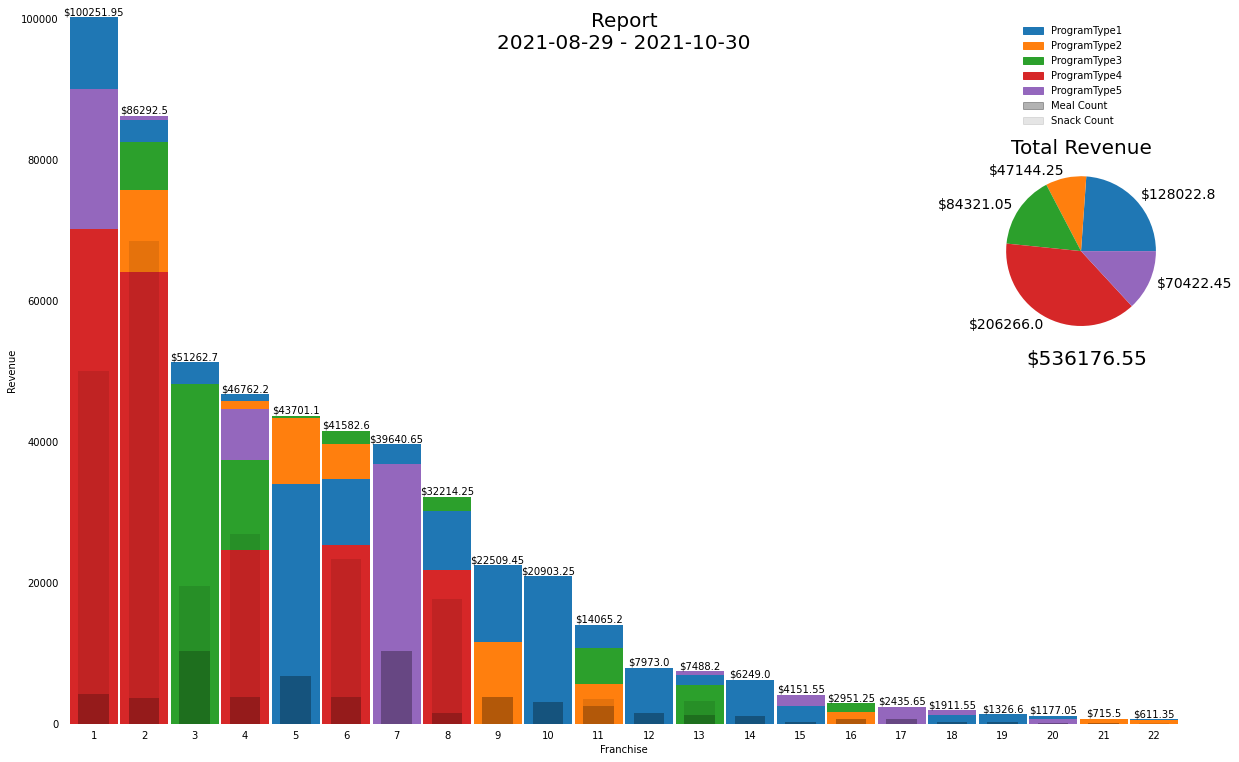

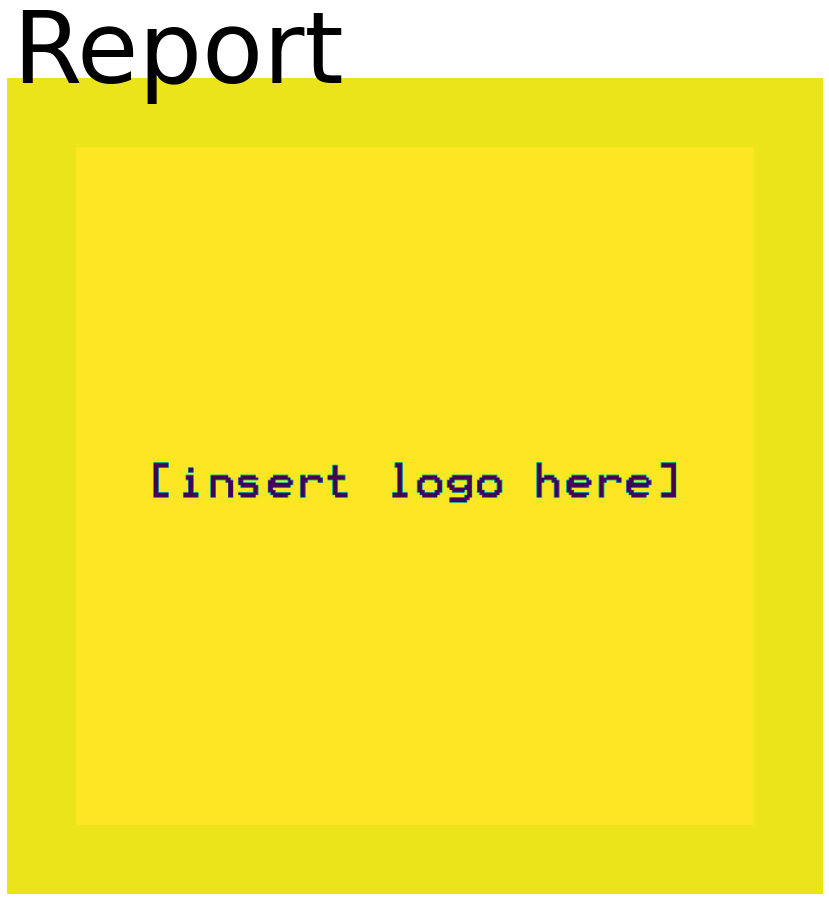

In [24]:
report_maker('2021-08-29','2021-10-30')